In [1]:
# Installing the packages that will be used. The "!" on the commands it's for use in the OS, out of Jupyter.
# This is for use SQLite
!pip install -q imdb-sqlite
# This is for use the countries name and abbreviations
!pip install -q pycountry

In [2]:
# Importing the necessary packages and ignoring some warnings
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [3]:
# Jupyter command for see the execution time
%time
# Download data from IMDB
!imdb-sqlite

Wall time: 0 ns


2021-09-05 14:22:01,659 DB already exists: (imdb.db). Refusing to modify. Exiting


In [4]:
# Connecting to database
conn = sqlite3.connect("imdb.db")
# Makes a table list
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)
# Show the result
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [6]:
# Converting dataframe to a list
tabelas = tabelas["Table_Name"].values.tolist()
# Extracting the list
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




### What's the Longest Running Movie?

In [7]:
# Makes a SQL consult
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''
# Results
resultado6 = pd.read_sql_query(consulta6, conn)
# Show the result
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
369238,123
369239,57
369240,100
369241,116


In [8]:
# Calculanting the percentile
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [22]:
# Longest movie
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''
resultado6 = pd.read_sql_query(consulta6, conn)
nome = resultado6['primary_title'].to_string()
duracao = resultado6['Runtime'].to_string()
print('O filme mais longo é o', nome ,'com duração de', duracao, 'minutos')

O filme mais longo é o 0    Logistics com duração de 0    51420 minutos


### What is the relation between duration and genre

In [24]:
# Creating a function to return the genres
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [25]:
# Makes a SQL consult
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''

# Result
resultado7 = pd.read_sql_query(consulta7, conn)
# Unique genre
generos_unicos = retorna_generos(resultado7)
# Show the result
display(generos_unicos)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [26]:
# Genre duration
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [27]:
# Dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime
# Remove 18
df_genero_runtime = df_genero_runtime.drop(index = 18)
# Order
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

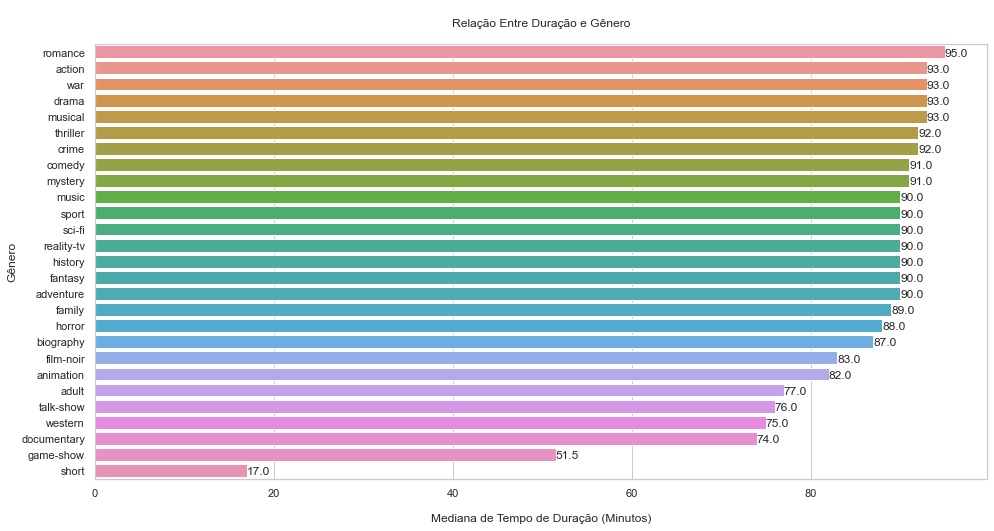

In [28]:
# Plot
plt.figure(figsize = (16,8))
# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")
# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))
plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

### What is the number of films produced by country?

In [29]:
# Makes a SQL consult
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            '''
# Result
resultado8 = pd.read_sql_query(consulta8, conn)
# Show the result
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,432
2,AF,109
3,AG,12
4,AL,1234
...,...,...
229,YUCS,146
230,ZA,3036
231,ZM,11
232,ZRCD,2


In [30]:
# Number of line
resultado8.shape[0]
# Empty list
nomes_paises = []
contagem = []

In [31]:
# Countries according to region
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [32]:
# Dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem
# Result
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)
# Visualization
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,293743
65,United Kingdom,149568
96,Japan,88673
63,France,81668
89,India,73549
32,Canada,69754
47,Germany,66397
93,Italy,63572
26,Brazil,62498
58,Spain,62235


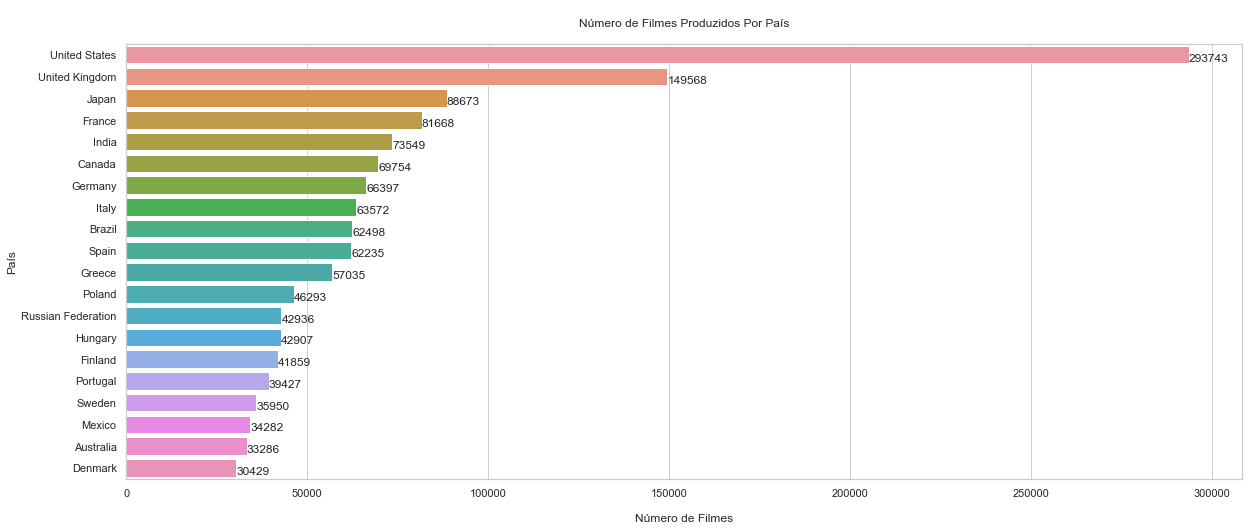

In [33]:
# Plot
plt.figure(figsize = (20,8))
# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")
# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))
plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

### What are the Top 10 Best Movies?

In [34]:
# Makes a SQL consult
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            '''
# Result
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)
# Show the result
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


### What are the Top 10 Worst Movies

In [36]:
# Makes a SQL consult
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10          
            '''
# Result
top10_piores_filmes = pd.read_sql_query(consulta10, conn)
# Show the result
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
